# Workflow Simulation Analysis Dashboard

This notebook provides interactive analysis of workflow simulation metrics.


In [1]:
import json
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


## Load Simulation Data

First, let's load all the simulation results from the JSON files.


In [2]:
def load_simulation_data(results_dir="results"):
    """Load all simulation results into a pandas DataFrame."""
    all_results = []
    
    for json_file in Path(results_dir).rglob("*.json"):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            
            # Extract metrics
            metrics = data.get('metrics', {})
            
            # Add file metadata
            metrics['file_path'] = str(json_file)
            metrics['workflow_name'] = json_file.stem
            metrics['category'] = json_file.parent.name
            
            all_results.append(metrics)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    df = pd.DataFrame(all_results)
    return df

# Load the data - you can specify a specific directory or load all results
# Option 1: Load all results
df = load_simulation_data("results/others/5tasks_fullsim")

# Option 2: Load specific directory (uncomment and use instead)
# df = load_simulation_data("results/others/5tasks_fullsim")

print(f"Loaded {len(df)} simulation results")
print(f"\nColumns: {df.columns.tolist()}")

# Sort by composition number to ensure consistent plot ordering
if 'composition_number' in df.columns:
    df = df.sort_values(by='composition_number', ascending=True).reset_index(drop=True)
    # Create ordered categorical type for workflow_name to maintain sorting in plots
    df['workflow_name'] = pd.Categorical(df['workflow_name'], 
                                         categories=df['workflow_name'].tolist(), 
                                         ordered=True)
    print(f"\nSorted by composition_number")
    print(f"Composition range: {df['composition_number'].min()} to {df['composition_number'].max()}")

print(f"\nData sample:")
df.head()


Loaded 16 simulation results

Columns: ['workflow_id', 'composition_number', 'total_events', 'total_tasksets', 'total_groups', 'total_jobs', 'total_wall_time', 'total_turnaround_time', 'wall_time_per_event', 'cpu_time_per_event', 'network_transfer_mb_per_event', 'event_throughput', 'success_rate', 'total_cpu_used_time', 'total_cpu_allocated_time', 'total_write_local_mb', 'total_write_remote_mb', 'total_read_remote_mb', 'total_read_local_mb', 'total_network_transfer_mb', 'total_write_local_mb_per_event', 'total_write_remote_mb_per_event', 'total_read_remote_mb_per_event', 'total_read_local_mb_per_event', 'cpu_utilization', 'memory_occupancy', 'total_cpu_cores_used', 'total_memory_used_mb', 'cpu_cores_per_event', 'memory_mb_per_event', 'file_path', 'workflow_name', 'category']

Sorted by composition_number
Composition range: 1 to 16

Data sample:


,workflow_id,composition_number,total_events,total_tasksets,total_groups,total_jobs,total_wall_time,total_turnaround_time,wall_time_per_event,cpu_time_per_event,...,total_read_local_mb_per_event,cpu_utilization,memory_occupancy,total_cpu_cores_used,total_memory_used_mb,cpu_cores_per_event,memory_mb_per_event,file_path,workflow_name,category
0,templates/others/5tasks_fullsim/5tasks_fullsim...,1,2666667,5,1,485,2.093547e+07,43195.1016,7.8508,62.8064,...,1.652344,0.606359,0.893641,3880,3880000,0.001455,1.455,results/others/5tasks_fullsim/5tasks_fullsim_c...,5tasks_fullsim_composition_001,5tasks_fullsim
1,templates/others/5tasks_fullsim/5tasks_fullsim...,2,2666667,5,2,486,2.093547e+07,86393.4174,7.8508,61.4456,...,1.505859,0.805588,0.944412,3800,3888000,0.001425,1.458,results/others/5tasks_fullsim/5tasks_fullsim_c...,5tasks_fullsim_composition_002,5tasks_fullsim
2,templates/others/5tasks_fullsim/5tasks_fullsim...,3,2666667,5,2,485,2.093547e+07,86396.4976,7.8508,57.4456,...,1.254883,0.814126,0.935874,3548,3880000,0.001330,1.455,results/others/5tasks_fullsim/5tasks_fullsim_c...,5tasks_fullsim_composition_003,5tasks_fullsim
3,templates/others/5tasks_fullsim/5tasks_fullsim...,4,2666667,5,2,486,2.093547e+07,86397.1712,7.8508,38.0832,...,0.934570,1.000000,1.000000,2360,3472000,0.000885,1.302,results/others/5tasks_fullsim/5tasks_fullsim_c...,5tasks_fullsim_composition_004,5tasks_fullsim
4,templates/others/5tasks_fullsim/5tasks_fullsim...,5,2666667,5,2,485,2.093547e+07,86397.8784,7.8508,49.9952,...,1.261719,0.839824,0.910176,3088,3880000,0.001158,1.455,results/others/5tasks_fullsim/5tasks_fullsim_c...,5tasks_fullsim_composition_005,5tasks_fullsim


## Resource Utilization Analysis


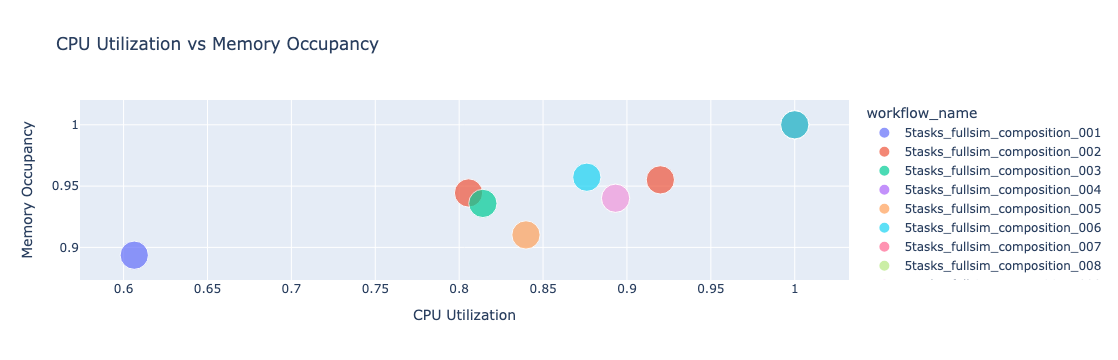

In [3]:
# Create CPU vs Memory utilization scatter plot
fig = px.scatter(
    df,
    x='cpu_utilization',
    y='memory_occupancy',
    color='workflow_name',
    size='total_events',
    hover_data=['total_cpu_cores_used', 'total_memory_used_mb', 'event_throughput'],
    title="CPU Utilization vs Memory Occupancy",
    labels={
        'cpu_utilization': 'CPU Utilization',
        'memory_occupancy': 'Memory Occupancy'
    }
)
fig.show()


## I/O Pattern Analysis


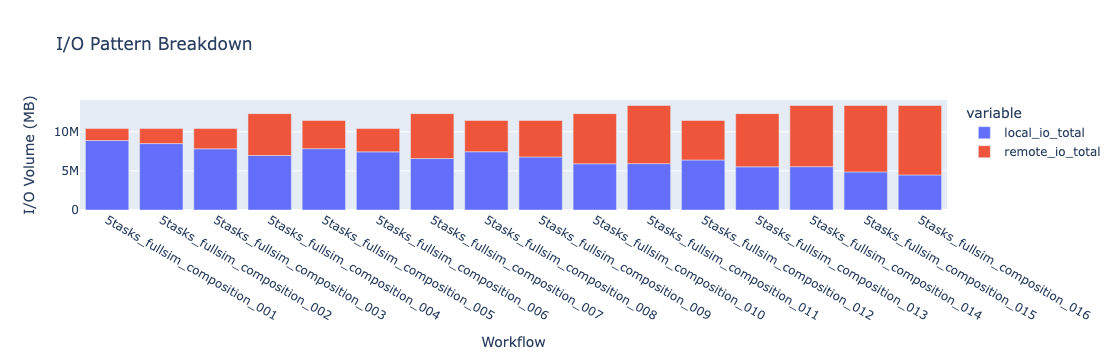

In [4]:
# Calculate I/O ratios
df['local_io_total'] = df['total_write_local_mb'] + df['total_read_local_mb']
df['remote_io_total'] = df['total_write_remote_mb'] + df['total_read_remote_mb']
df['total_io'] = df['local_io_total'] + df['remote_io_total']
df['local_io_ratio'] = df['local_io_total'] / df['total_io']
df['remote_io_ratio'] = df['remote_io_total'] / df['total_io']

# Create I/O pattern visualization
fig = px.bar(
    df,
    x='workflow_name',
    y=['local_io_total', 'remote_io_total'],
    title="I/O Pattern Breakdown",
    labels={'value': 'I/O Volume (MB)', 'workflow_name': 'Workflow'}
)
fig.show()


## Performance Metrics


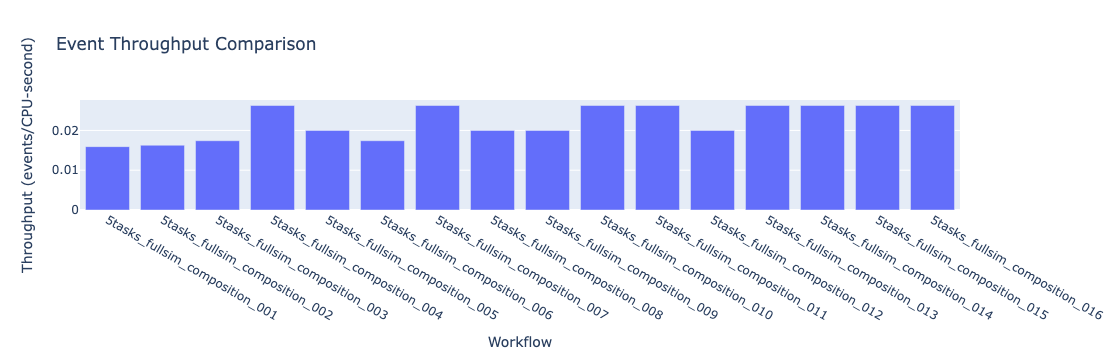

In [5]:
# Event throughput comparison
fig = px.bar(
    df,
    x='workflow_name',
    y='event_throughput',
    title="Event Throughput Comparison",
    labels={'event_throughput': 'Throughput (events/CPU-second)', 'workflow_name': 'Workflow'}
)
fig.show()


## Cost Analysis


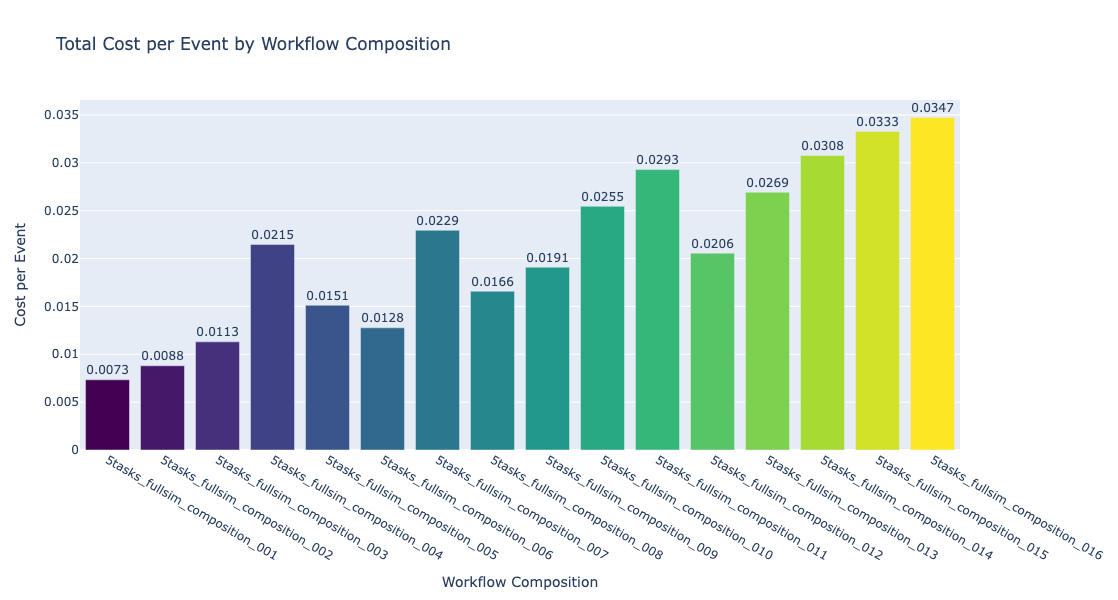


=== Cost Efficiency ===
                 workflow_name  total_cost_per_event  event_throughput  cost_efficiency
5tasks_fullsim_composition_001              0.007333          0.015922         2.171296
5tasks_fullsim_composition_002              0.008798          0.016275         1.849851
5tasks_fullsim_composition_003              0.011295          0.017408         1.541182
5tasks_fullsim_composition_006              0.012763          0.017408         1.363917
5tasks_fullsim_composition_005              0.015116          0.020002         1.323253
5tasks_fullsim_composition_004              0.021478          0.026258         1.222545
5tasks_fullsim_composition_008              0.016584          0.020002         1.206118
5tasks_fullsim_composition_007              0.022946          0.026258         1.144333
5tasks_fullsim_composition_009              0.019090          0.020002         1.047751
5tasks_fullsim_composition_010              0.025453          0.026258         1.031639
5tasks_

In [6]:
# Calculate cost metrics
# Cost rationale: We estimate operational costs by combining CPU, memory, and network resource usage.
# Multipliers represent unit costs: $0.1 per CPU-core, $0.001 per MB memory, $0.01 per MB network transfer.
# This provides a unified cost metric to compare workflow efficiency across different compositions.
df['cpu_cost_per_event'] = df['cpu_cores_per_event'] * 0.1
df['memory_cost_per_event'] = df['memory_mb_per_event'] * 0.001
df['network_cost_per_event'] = df['network_transfer_mb_per_event'] * 0.01
df['total_cost_per_event'] = df['cpu_cost_per_event'] + df['memory_cost_per_event'] + df['network_cost_per_event']

# Cost per Event visualization
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=df['workflow_name'],
        y=df['total_cost_per_event'],
        marker_color=df['composition_number'],
        marker_colorscale='Viridis',
        text=df['total_cost_per_event'].round(4),
        textposition='outside',
        name='Total Cost per Event'
    )
)

fig.update_layout(
    height=600,
    title_text="Total Cost per Event by Workflow Composition",
    xaxis_title="Workflow Composition",
    yaxis_title="Cost per Event",
    showlegend=False
)

fig.show()

# Also show a cost efficiency metric
print("\n=== Cost Efficiency ===")
df['cost_efficiency'] = df['event_throughput'] / df['total_cost_per_event']
df_efficiency = df[['workflow_name', 'total_cost_per_event', 'event_throughput', 'cost_efficiency']].sort_values('cost_efficiency', ascending=False)
print(df_efficiency.to_string(index=False))


## Interactive Analysis

Use the widget below to create custom visualizations by selecting different metrics to compare.


In [7]:
# Get numeric column names
numeric_cols = ['cpu_utilization', 'memory_occupancy', 'event_throughput', 
                'total_wall_time', 'cpu_cores_per_event', 'memory_mb_per_event',
                'network_transfer_mb_per_event', 'total_cost_per_event']

@interact(
    x_axis=widgets.Dropdown(options=numeric_cols, value='event_throughput', description='X-axis:'),
    y_axis=widgets.Dropdown(options=numeric_cols, value='cpu_utilization', description='Y-axis:'),
    color_by=widgets.Dropdown(options=['workflow_name', 'category'], value='workflow_name', description='Color by:'),
    plot_type=widgets.Dropdown(options=['scatter', 'bar', 'line'], value='scatter', description='Plot type:')
)
def create_custom_plot(x_axis, y_axis, color_by, plot_type):
    """Create custom interactive plots."""
    
    if plot_type == 'scatter':
        fig = px.scatter(
            df,
            x=x_axis,
            y=y_axis,
            color=color_by,
            hover_data=['workflow_name'],
            title=f"{x_axis.replace('_', ' ').title()} vs {y_axis.replace('_', ' ').title()}"
        )
    elif plot_type == 'bar':
        fig = px.bar(
            df,
            x=color_by,
            y=y_axis,
            color=color_by,
            title=f"{y_axis.replace('_', ' ').title()} by {color_by.replace('_', ' ').title()}"
        )
    else:  # line
        fig = px.line(
            df,
            x=x_axis,
            y=y_axis,
            color=color_by,
            title=f"{x_axis.replace('_', ' ').title()} vs {y_axis.replace('_', ' ').title()}"
        )
    
    fig.show()


interactive(children=(Dropdown(description='X-axis:', index=2, options=('cpu_utilization', 'memory_occupancy',…